In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from functools import partial

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.config import Config
from src.episode import Episode
from src.episode_dataset import EpisodeDataset
from src.policy import Policy
from src.reward_model import RewardModel
from src.grpo_trainer import GRPOTrainer
from src.utils import get_color, normalize_min_max, to_device_collate, top_k_sampling
from src.episode_batch_reat_sampler import EpisodeBatchRepeatSampler

# Setup
---

In [2]:
config = Config()

# Datasets

train_dataset = EpisodeDataset(config=config, split="TRAIN")
print(f"train_dataset : {len(train_dataset)}")

test_dataset = EpisodeDataset(config=config, split="TEST")
print(f"test_dataset : {len(test_dataset)}")

eval_dataset = EpisodeDataset(config=config, split="EVAL")
print(f"eval_dataset : {len(eval_dataset)}")


# DataLoaders
def get_data_loader(dataset: EpisodeDataset, batch_size: int, repeats: int):
    batch_repeat_sampler = EpisodeBatchRepeatSampler(
        dataset=dataset,
        batch_size=batch_size,
        repeats=repeats,
    )
    print(f"batch_repeat_sampler: {list(batch_repeat_sampler)}")

    to_device_collate_configurable = partial(to_device_collate, config.device)
    dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=batch_repeat_sampler,
        collate_fn=to_device_collate_configurable,
    )
    return dataloader


train_dataloader = get_data_loader(
    dataset=train_dataset,
    batch_size=config.train_batch_size,
    repeats=config.episode_steps,
)
test_dataloader = get_data_loader(
    dataset=test_dataset,
    batch_size=config.test_batch_size,
    repeats=config.episode_steps,
)

eval_dataloader = get_data_loader(
    dataset=eval_dataset,
    batch_size=config.eval_batch_size,
    repeats=config.episode_steps,
)

train_dataset : 1000
test_dataset : 2000
eval_dataset : 2000
batch_repeat_sampler: [604, 10, 18, 591, 9, 183, 804, 34, 380, 859, 503, 442, 199, 544, 187, 468, 102, 67, 728, 361, 842, 646, 502, 231, 319, 359, 930, 228, 755, 374, 111, 533, 3, 882, 0, 267, 376, 732, 844, 320, 596, 386, 396, 809, 642, 129, 335, 49, 275, 618, 604, 10, 18, 591, 9, 183, 804, 34, 380, 859, 503, 442, 199, 544, 187, 468, 102, 67, 728, 361, 842, 646, 502, 231, 319, 359, 930, 228, 755, 374, 111, 533, 3, 882, 0, 267, 376, 732, 844, 320, 596, 386, 396, 809, 642, 129, 335, 49, 275, 618, 604, 10, 18, 591, 9, 183, 804, 34, 380, 859, 503, 442, 199, 544, 187, 468, 102, 67, 728, 361, 842, 646, 502, 231, 319, 359, 930, 228, 755, 374, 111, 533, 3, 882, 0, 267, 376, 732, 844, 320, 596, 386, 396, 809, 642, 129, 335, 49, 275, 618, 604, 10, 18, 591, 9, 183, 804, 34, 380, 859, 503, 442, 199, 544, 187, 468, 102, 67, 728, 361, 842, 646, 502, 231, 319, 359, 930, 228, 755, 374, 111, 533, 3, 882, 0, 267, 376, 732, 844, 320, 596, 386,

fov: torch.Size([11, 11])


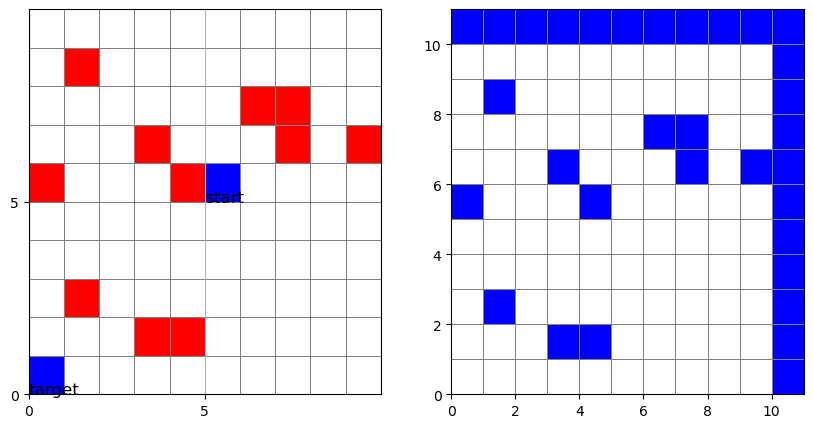

In [3]:
episode1 = train_dataset.episodes[0]

# Viz world
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
episode1.viz(ax=axes[0])

# Viz fov
fov = episode1.world.fov(center_pos=episode1.agent.start_state.position())
print(f"fov: {fov.size()}")
# print(f"fov: {fov}")
episode1.world.viz_fov(center_pos=episode1.agent.start_state.position(), ax=axes[1])
plt.show()

In [4]:
def train_and_plot_policy(policy: Policy, debug: bool = False):
    episode = Episode.new(id="train")
    print(f"start: {episode.agent.current_state}")
    episode.train(steps=20, policy=policy, debug=debug)
    print(f"start2: {episode.agent.current_state}")

    fig = plt.figure(figsize=config.figure_size)
    ax = fig.add_subplot(1, 1, 1)
    episode.viz(ax=ax, color=get_color(0))
    plt.show()

    return episode


def inference_and_plot_policy(policy: Policy, steps: int = 20, debug: bool = False):
    episode = Episode.new(id="inference")
    # print(f"start state: {episode.agent.start_state}")
    # print(f"target state: {episode.agent.target_state}")
    episode.inference_steps_by_policy(steps=steps, policy=policy, debug=debug)
    # print(f"end state: {episode.agent.current_state}")

    fig = plt.figure(figsize=config.figure_size)
    ax = fig.add_subplot(1, 1, 1)
    episode.viz(ax=ax, color=get_color(0))
    plt.show()

    return episode

step: 0, logits: tensor([[-0.5165,  3.2063, -0.8446,  1.1429, -0.2882, -1.4254,  2.1762, -0.5895,
          0.5215]]), logit_prob: tensor([[0.1944]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[1]]), state: tensor([4, 5]), action_history: [tensor(1)]
step: 1, logits: tensor([[-1.1796,  2.0594,  0.0850,  1.8347, -0.3206, -1.2442,  2.1717,  0.1790,
          0.3296]]), logit_prob: tensor([[0.1729]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[6]]), state: tensor([5, 4]), action_history: [tensor(1), tensor(6)]
step: 2, logits: tensor([[ 0.2384,  2.1754, -0.2205,  0.8866, -0.0759, -1.2152,  1.7308, -1.1389,
          1.1140]]), logit_prob: tensor([[0.1783]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[1]]), state: tensor([4, 4]), action_history: [tensor(1), tensor(6), tensor(1)]
step: 3, logits: tensor([[-0.4205,  2.3283, -0.6025,  1.6564,  0.2169, -1.2275,  1.3082,  0.6557,
         -0.4392]]), logit_prob: tensor([[0.1824]]), top_k_prob: tensor([[1.]]), action_idx: tenso

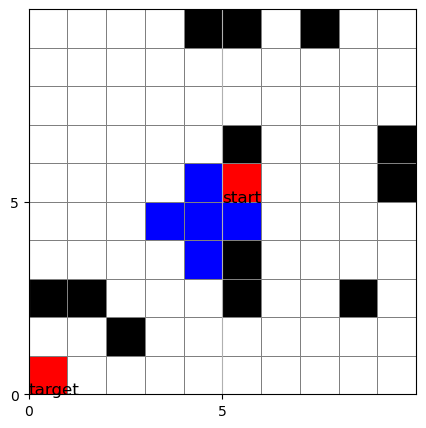

In [5]:
test_policy = Policy(config=config)
episode = inference_and_plot_policy(policy=test_policy, steps=5, debug=True)
# episode.agent.action_history

# Training Loop
---

In [6]:
policy = Policy(config=config)
reward_model = RewardModel(config=config)
trainer = GRPOTrainer(config=config, policy=policy, reward_model=reward_model)

step: 0, logits: tensor([[-0.5202,  2.1735,  0.0953,  0.6111, -0.7674, -1.3197,  1.9295, -0.8591,
          0.7489]]), logit_prob: tensor([[0.1828]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[1]]), state: tensor([4, 5]), action_history: [tensor(1)]
step: 1, logits: tensor([[-1.5224,  3.1850,  0.1266,  1.5098, -0.0729, -1.0985,  2.4551,  0.7653,
          0.6275]]), logit_prob: tensor([[0.1809]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[1]]), state: tensor([3, 5]), action_history: [tensor(1), tensor(1)]
step: 2, logits: tensor([[-0.3098,  2.3595, -0.2866,  0.9646,  0.6606, -0.9279,  1.8791, -0.5576,
          0.4316]]), logit_prob: tensor([[0.1872]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[1]]), state: tensor([2, 5]), action_history: [tensor(1), tensor(1), tensor(1)]
step: 3, logits: tensor([[-0.9094,  1.8944,  0.4604,  1.4061,  0.5985, -0.4931,  1.0512,  0.0834,
         -0.3736]]), logit_prob: tensor([[0.1794]]), top_k_prob: tensor([[1.]]), action_idx: tenso

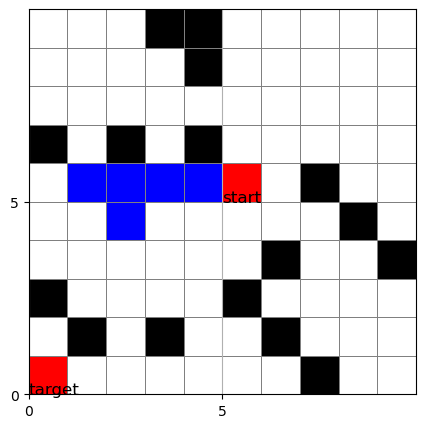

In [7]:
# Before tarin, policy behavior
episode = inference_and_plot_policy(policy=test_policy, steps=5, debug=True)

In [8]:
trainer.run(train_dataset=train_dataset, eval_dataset=eval_dataset, debug=False)

batch_repeat_sampler: [350, 806, 180, 773, 438, 994, 674, 271, 820, 533, 416, 837, 273, 520, 694, 607, 664, 185, 497, 708, 714, 973, 466, 586, 448, 581, 559, 841, 824, 930, 723, 418, 86, 821, 736, 98, 633, 574, 195, 864, 76, 10, 333, 819, 951, 473, 327, 676, 711, 570, 350, 806, 180, 773, 438, 994, 674, 271, 820, 533, 416, 837, 273, 520, 694, 607, 664, 185, 497, 708, 714, 973, 466, 586, 448, 581, 559, 841, 824, 930, 723, 418, 86, 821, 736, 98, 633, 574, 195, 864, 76, 10, 333, 819, 951, 473, 327, 676, 711, 570, 350, 806, 180, 773, 438, 994, 674, 271, 820, 533, 416, 837, 273, 520, 694, 607, 664, 185, 497, 708, 714, 973, 466, 586, 448, 581, 559, 841, 824, 930, 723, 418, 86, 821, 736, 98, 633, 574, 195, 864, 76, 10, 333, 819, 951, 473, 327, 676, 711, 570, 350, 806, 180, 773, 438, 994, 674, 271, 820, 533, 416, 837, 273, 520, 694, 607, 664, 185, 497, 708, 714, 973, 466, 586, 448, 581, 559, 841, 824, 930, 723, 418, 86, 821, 736, 98, 633, 574, 195, 864, 76, 10, 333, 819, 951, 473, 327, 676, 711

/Users/chengbai/ml/cheng_git/rf_agent/src/reward_model.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dxy = torch.tensor(action.get_udpate())


step: 0, logits: tensor([[-6339489.0000,   670434.6250,   567971.8125,   533258.1875,
           217483.4375,   581471.8750,   613222.9375,   640685.7500,
           633775.6250]]), logit_prob: tensor([[0.1213]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[1]]), state: tensor([4, 5]), action_history: [tensor(1)]
step: 1, logits: tensor([[-7011347.0000,   725341.0625,   611739.5000,   578451.8750,
           237642.0156,   648272.8750,   664841.1875,   718578.7500,
           696821.0625]]), logit_prob: tensor([[0.1212]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[1]]), state: tensor([3, 5]), action_history: [tensor(1), tensor(1)]
step: 2, logits: tensor([[-7918961.5000,   817729.9375,   690758.6250,   654191.7500,
           267620.7188,   735295.1250,   751435.6250,   815086.0000,
           788329.5625]]), logit_prob: tensor([[0.1212]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[1]]), state: tensor([2, 5]), action_history: [tensor(1), tensor(1), tensor(1)]
step: 3

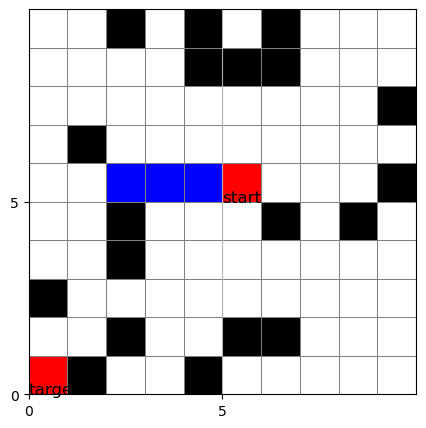

episode reward: -44.332054138183594


In [10]:
episode = inference_and_plot_policy(
    policy=policy, steps=config.episode_steps, debug=True
)
print(f"episode reward: {episode.reward(reward_model=reward_model)}")